# TEXT-MINING: Analysis of LeMonde tweets
Guillaume Béguec, Théo Cavenne & Baptiste Gorteau

---

### Imports

---

In [28]:
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import datetime
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
from unidecode import unidecode
from spellchecker import SpellChecker
from datetime import datetime
from nltk.util import ngrams
import spacy
nlp = spacy.load('fr_core_news_md')

## Introduction

---

The main objective of our project was to use natural language processing techniques to analyze the tweets of the newspaper Le Monde, in order to observe current affairs themes and trends. To do this, we collected a large number of tweets published by Le Monde and used various text analysis techniques to extract meaningful information from the data. The data collection is presented in the file `twitter_generate_data.py`.

In this study, we explored different approaches to processing and analyzing the newspaper's tweets, using both data processing and analytical tools. We also examined the different ways in which these tweets reflect current events and topics that are popular with Le Monde readers.

Throughout this project, we'll be looking at tweets from 2022, enabling us to address our problem for this data. 

Initially, we focused on studying the data and how we could clean it up. Next, we decided to focus our analysis on a global view of themes, using a Name Entity Recognition model. Finally, in the last part we focused on a more precise view of the themes, using NMF, a useful tool for NLP text analysis, which enables us to discover hidden themes in a corpus of documents in an efficient way.

## Data pre-processing

---

The aim of this section is to carry out initial processing on our data, before moving on to textual processing.

In [3]:
# data import
data = pd.read_csv("data/tweets_lemonde.csv")

# convert date variable to datetime format
data["date"] = pd.to_datetime(data["date"], format='%Y-%m-%d %H:%M:%S+00:00')

Some tweets are retweets from other accounts, or even from LeMonde comple. We have therefore decided to remove them

In [4]:
data["is_RT"] = ["RT " in i[:3] for i in data["content"]]
data = data[data["is_RT"] == False]
data = data.drop(["is_RT"], axis=1)

We also decided to work on our analysis of tweets from 2022. We therefore create the associated dataframe:

In [5]:
data_2022 = data[data['date']>'2022']  

To reduce calculation time, we decided to use the `like_count` variable, to select only those tweets that were at least popular.

In [6]:
data_2022 = data_2022[data_2022['like_count']>100]

We're now going to take a look at text processing for our tweets. Before doing so, it was important for us to list the various issues and techniques that might be of interest.

- Tweets are very similar to SMS language. Emojis can be spotted, and should be removed.
- As the LeMonde account is professional, we assume that spelling mistakes will be rare.
- Tweets often contain quoted usernames, marked with an @, or links to other web pages, which should be deleted.
- Tweets may contain hashtags, marked with a #, which should be deleted.
- Most textual treatments also apply, such as the removal of punctuation and special characters, lemmatization and the deletion of stopwords.

## Text processing

---

### Functions

In [7]:
# this function allows us to decipher our dataset
def describe(data):
    desc_num = pd.DataFrame(data.rt_count.describe())
    desc_num["like_count"] = data.like_count.describe()
    print(desc_num)
    desc_cat = pd.DataFrame(data.content.describe())
    print(desc_cat)

In [8]:
# deleting hashtags
def remove_hashtags(tweet):
    return re.sub(r'(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

In [9]:
# deleting links
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'https\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    return tweet

In [10]:
# deleting usernames
def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet

In [11]:
# deleting emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

The following function deletes punctuation and special characters. We've decided to replace these characters differently, depending on their type. For "-", "_" and "'", we replace them with a space. For the others, we delete them.

In [12]:
def remove_symbols_and_punctuation(tweet) :
    list_symbols = ["!",'"',"\$","%","&",'\\\\', "\(", "\)", "\*", "\+", "\.", "/",":",";",",","<","=",">","\?","\[","\]","\^","`","{","\|","}","~","•","@", "<<", ">>", "\n"]
    list_punctuation = ["-", "_", "'"]
    tweet_list = tweet.split(" ")
    new_tweet_list = []
    for word in tweet_list :
        for symbol in list_symbols : 
            word = re.sub(symbol, '', word)
        for punc in list_punctuation :
            word = re.sub(punc, ' ', word)
        for i in word.split(" ") :  
            if i != '' :
                new_tweet_list.append(i)
    return ' '.join(new_tweet_list)

In [14]:
# lemmatization des tweets
def lemmatize_tweet(tweet_content) :
    list_lemmatize = []
    doc = nlp(tweet_content)
    for token in doc:
        list_lemmatize.append(token.lemma_)
    return ' '.join(list_lemmatize)

### First analyses

Let's take a look at some preliminary descriptive analyses of our dataset

In [15]:
describe(data)

            rt_count     like_count
count  324207.000000  324207.000000
mean       31.732513      37.561240
std        88.945735     116.717558
min         0.000000       0.000000
25%         7.000000       5.000000
50%        16.000000      18.000000
75%        33.000000      37.000000
max     21873.000000   18703.000000
                                                  content
count                                              324207
unique                                             323687
top     Voici la une du « Monde » bouclée à l'instant ...
freq                                                  187


In [16]:
describe(data_2022)

          rt_count   like_count
count  2616.000000  2616.000000
mean    100.158639   256.226300
std     184.862097   394.277799
min       6.000000   101.000000
25%      39.000000   123.000000
50%      59.500000   161.000000
75%      98.000000   249.000000
max    4138.000000  8536.000000
                                                  content
count                                                2616
unique                                               2616
top     Alors qu’il avait assuré ne pas vouloir « poli...
freq                                                    1


### Stopwords

Before deleting them, we need to be able to identify them. As tweets can potentially be in both English and French, we have chosen to concatenate the 2 lists of stopwords provided by nltk. We add a recovered list, adding more French stopwords.

In [19]:
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_fr = nltk.corpus.stopwords.words('french')
with open('data/stopwords-fr.txt') as f:
    stopwords_fr_2 = f.readlines()
stopwords_fr_2 = [i[:-1] for i in stopwords_fr_2]
my_stopwords = stopwords_en+stopwords_fr+stopwords_fr_2

### Cleaning function

We can now use our previously created functions to clean up our tweets.

In [20]:
def clean_tweet(tweet):
    # remove users
    tweet = remove_users(tweet)
    
    # remove hashtags
    tweet = remove_hashtags(tweet)
    
    # remove emoji
    tweet = remove_emoji(tweet)
    
    # remove links
    tweet = remove_links(tweet)
    
    # remove accents
    tweet = unidecode(tweet)
    
    # remove punctuation
    tweet = remove_symbols_and_punctuation(tweet)
    
    # passage en minuscule
    tweet = tweet.lower()
    
    # Apply stopwords 
    tweet  = [word for word in tweet.split(' ') if word not in my_stopwords]
    tweet  = ' '.join(tweet)
    
    # Lemmatisation :
    tweet = lemmatize_tweet(tweet)
    
    return tweet

Let's look at the result on the first five lines :

In [22]:
data_2022['clean_tweet'] = data_2022.content.apply(clean_tweet)

data_2022[["clean_tweet", "content"]].head(5)

,clean_tweet,content
41,assure vouloir politiser sport emmanuel macron...,Alors qu’il avait assuré ne pas vouloir « poli...
106,empecher glisser regard coin inscrire triple f...,Il n’a pas pu s’empêcher de lui glisser un reg...
108,coupe monde 2022 histoire presque parfait equi...,Coupe du monde 2022 | L’histoire presque parfa...
114,coupe monde 2022 argentine decroche troisiem t...,Coupe du monde 2022 : l’Argentine décroche un ...
118,albiceleste championne monde sacr mondial lion...,L’Albiceleste championne du monde | Le sacre m...


We can now realize a first vizualisation using a wordcloud :

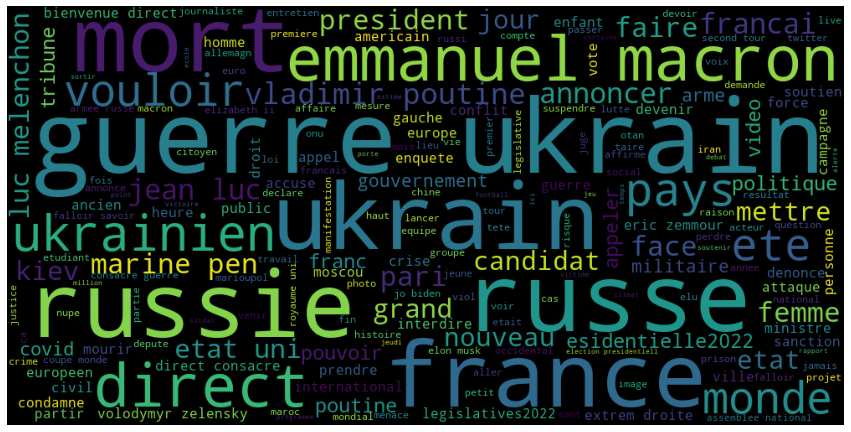

In [23]:
all_words = ' '.join([i for i in data_2022['clean_tweet']])
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=False).generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The result is not very significant, as we can see that most of the important words are proper nouns, or nouns that are not very indicative.  We can, however, get an initial idea of the themes addressed.

## Name Entity Recognition model

---

As we saw earlier, proper nouns play an important role in extracting themes from tweets.

In this first application, we'd like to get an idea, for a given year (here 2022), of the different personalities and places that were discussed. This approach would give us an overall idea of the main topics of discussion during that year. 
To answer this question, we decided on a 2-part approach: 
 - the first: use a NER model on our uncleaned tweets. This step will allow us, without removing the context of our tweets, to label the words among 4 tags: location (LOC), organizations (ORG), person (PER) and Miscellaneous (MISC).
 - the second is to keep only words tagged with location (LOC), organizations (ORG) and person (PER). If necessary, we can then apply our clean_tweet function. 

 Finally, we can use a wordcloud to get a good initial idea of the themes involved.

The NER model we're going to use is a BERT, trained and ready to be used for named entity recognition and achieves state-of-the-art performance for this task.

---

For further information: https://huggingface.co/dslim/bert-large-NER

---

The advantage of this model over Spacy's ner is the use of context. For example, the word group "Emmanuel Macron" will be taken into account in its entirety as a person. 

Le modèle pouvant être long à s'appliquer, nous décidons de ne travailler que sur les tweets les plus populaires,et nous fixons notre limite à 300likes cette fois-ci. 

In [24]:
data_2022_pop = data_2022[data_2022['like_count']>300]
data_2022_pop.shape

(471, 7)

In [25]:
# --- import des modules et chargement du modèle
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="max")

# liste de mots ne contenant que nos entités nommés, exceptés les MISC
prop_words = []
for index, tweet in data_2022_pop.iterrows():
    ner_results = nlp(tweet.content)
    words = []
    if ner_results != []:
        for entity in ner_results:
            if entity['entity_group']!="MISC":
                words.append(entity["word"])
        if " ".join(words) != '':
            prop_words.append(" ".join(words))
prop_words

['Emmanuel Macron',
 'ARGFRA',
 'Guadeloupe',
 'Laurent Wauquiez ’ François - Mitterrand Charlemagne',
 'Royaume Uni',
 'Les Bleus',
 'Le Maroc Portugal',
 'Antoine Arnault Bernard Arnault Christian Dior SE',
 'Emmanuel Macron',
 'OlivierDubois',
 'Cristina Kirchner',
 'Paris',
 'L ’ Iran',
 '’ ONU France Assa Traoré',
 'Antoine Griezmann',
 '’ Elisabeth Borne',
 'Cheb Khaled Cheb Hasni Cheb Mami',
 'Tunisie',
 'France Soir',
 'Unesco',
 'Shanghai Chine',
 'Julian Assange',
 'Bruxelles Belgique Maroc',
 'RRR',
 'Martine Wonner',
 'L ’',
 'Tony Gilroy',
 'Giorgia Meloni France Afrique',
 'Céline',
 'Taylor Swift SabrinaEl',
 'Mediapart',
 'Macron Afrique',
 'Maroc Casablanca',
 'Cyril Hanouna Lola',
 'Laure Beccuau Paris',
 'Danièle Obono',
 'Paris Özlem Délice Jussieu Lüks Sürpriz Impact Berliner',
 'Cyril Hanouna Louis Boyard l ’ Arcom',
 'Alger Ferhat Mehenni Mouvement pour la Kabylie',
 'les Phryges',
 'Manche',
 'France Pap Ndiaye Uni Rishi Sunak',
 'Cyril Hanouna LFI',
 'Yannick B

Finally, we can represent our new list, using a wordcloud:

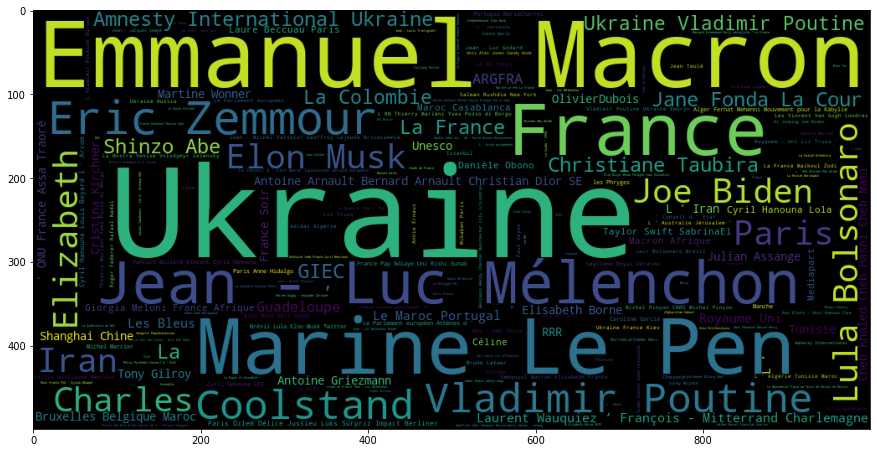

In [27]:
from collections import Counter
word_could_dict=Counter([word for word in prop_words])
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

This word cloud seems more meaningful, and clearly distinguishes a political environment within the personalities. However, the model doesn't need data cleaning to work.

After cleanning :

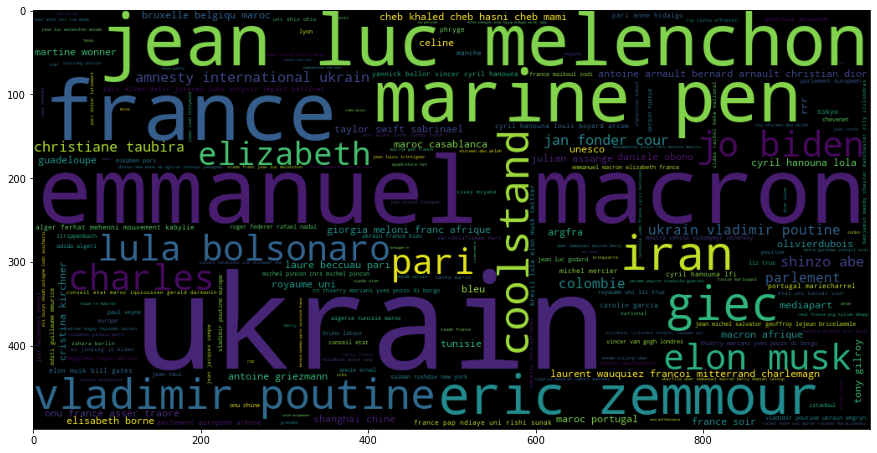

In [70]:
word_could_dict=Counter([clean_tweet(word) for word in prop_words])
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

# Topic modelling

---

To perform topic modeling, we'll use NMF.
Non-negative matrix factorization (NMF) is a tool commonly used in natural language processing (NLP) for text analysis and structure discovery. It decomposes a data matrix into two lower-dimensional matrices, so that the values of the original matrix are approximated by the multiplication of the two decomposed matrices.

NMF is often used in text analysis to discover hidden (latent) themes present in a corpus of documents. It can be used in a similar way to the LDA (Latent Dirichlet Allocation) algorithm, but we won't be using the latter.

In [45]:
# function to correctly display constructed themes
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [46]:
# create tf idf
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(data_2022["clean_tweet"]).toarray()
nmf = NMF(n_components=15, random_state=0, max_iter=500).fit(tf_idf)
feature_names = vectorizer.get_feature_names_out()

In [47]:
display_topics(nmf, feature_names, no_top_words=5)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights,Topic 12 words,Topic 12 weights,Topic 13 words,Topic 13 weights,Topic 14 words,Topic 14 weights
0,ukrain,2.1,macron,2.5,direct,1.6,etat,1.5,jean,1.1,...,pen,1.1,russie,1.7,france,1.2,presidentiell,0.9,ukrainien,1.0
1,guerre,2.1,emmanuel,2.4,consacre,1.3,uni,1.2,luc,1.0,...,marine,1.1,sanction,0.3,19,0.3,election,0.7,zelensky,1.0
2,crime,0.2,esidentielle2022,0.6,bienvenue,1.3,droit,0.5,melenchon,0.9,...,esidentielle2022,0.2,ukrain,0.2,covid,0.3,bresil,0.5,volodymyr,0.8
3,international,0.1,extrem,0.3,savoir,0.7,avortement,0.4,esidentielle2022,0.4,...,zemmour,0.2,union,0.2,euro,0.2,lula,0.5,president,0.6
4,europeen,0.1,droite,0.3,falloir,0.6,jo,0.3,godard,0.1,...,eric,0.2,invasion,0.2,passer,0.2,annoncer,0.5,kiev,0.3


The first topics we get seem to be interpretable in some cases, but not in others. The main themes that emerge are: the war in Ukraine and the presidential elections. 

Let's see what it looks like on our word list after the NER model:

In [76]:
# create tf idf
vectorizer = TfidfVectorizer(max_df=0.9, min_df=4)
tf_idf = vectorizer.fit_transform([clean_tweet(words) for words in prop_words]).toarray()
nmf = NMF(n_components=10, random_state=0, max_iter=500).fit(tf_idf)
feature_names = vectorizer.get_feature_names_out()

In [77]:
pd.options.display.max_columns = None
display_topics(nmf, feature_names, no_top_words=4)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,ukrain,2.6,macron,1.9,france,1.9,jean,1.5,pen,1.4,poutine,1.5,uni,1.6,eric,1.3,pari,1.7,kiev,1.5
1,otan,0.1,emmanuel,1.7,cyril,0.0,luc,1.0,marine,1.4,vladimir,1.1,etat,0.4,zemmour,1.1,monde,0.1,zelensky,0.5
2,marioupol,0.0,uber,0.2,onu,0.0,melenchon,1.0,monde,0.1,europe,0.2,cour,0.4,bolsonaro,0.2,melenchon,0.0,volodymyr,0.4
3,russie,0.0,europe,0.1,union,0.0,monde,0.1,union,0.1,zelensky,0.1,elizabeth,0.1,ukrain,0.0,marioupol,0.0,monde,0.3


The idea is very political, with themes linked to the war in Ukraine and other events.

## Conclusion

---

In conclusion, our project has enabled us to highlight trends and current affairs themes based on the analysis of tweets published by the newspaper Le Monde. The use of NMF (non-negative matrix factorization) and the various wordclouds enabled us to identify dominant political themes, while characteristics linked to personalities' proper names were processed using a BERT model.

Our results provide an interesting overview of the news covered by the newspaper, and an understanding of the topics that are important to its readers. For the year 2022, we mainly found political topics such as the war in Ukraine and the presidential elections. They also highlighted some of the limitations of our approach, particularly with regard to the names of personalities. We did not use bigrams and trigrams, but they could have been used here to link the proper names of public figures. The study also focuses on the most popular tweets of 2022, which should be taken into account.

Other approaches could have been 
All in all, this project has been a very rewarding experience that has put many NLP text analysis techniques into practice.

## Sources
---

- https://ourcodingclub.github.io/tutorials/topic-modelling-python/
- https://huggingface.co/dslim/bert-large-NER
- https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-explo-nmf.pdf
- https://github.com/JustAnotherArchivist/snscrape
